In [5]:
# Adding the part of code mentioned in the pdf below

#Uses pillow (you can also use another imaging library if you want)
from PIL import Image, ImageOps, ImageFont, ImageDraw

#Load the font and set the font size to 42
font = ImageFont.truetype('habbakuk/Habbakuk.ttf', 42)

#Character mapping for each of the 27 tokens
char_map = {'Alef' : ')', 
            'Ayin' : '(', 
            'Bet' : 'b', 
            'Dalet' : 'd', 
            'Gimel' : 'g', 
            'He' : 'x', 
            'Het' : 'h', 
            'Kaf' : 'k', 
            'Kaf-final' : '\\', 
            'Lamed' : 'l', 
            'Mem' : '{', 
            'Mem-medial' : 'm', 
            'Nun-final' : '}', 
            'Nun-medial' : 'n', 
            'Pe' : 'p', 
            'Pe-final' : 'v', 
            'Qof' : 'q', 
            'Resh' : 'r', 
            'Samekh' : 's', 
            'Shin' : '$', 
            'Taw' : 't', 
            'Tet' : '+', 
            'Tsadi-final' : 'j', 
            'Tsadi-medial' : 'c', 
            'Waw' : 'w', 
            'Yod' : 'y', 
            'Zayin' : 'z'}

#Returns a grayscale image based on specified label of img_size
def create_image(label, img_size):
    if (label not in char_map):
        raise KeyError('Unknown label!')

    #Create blank image and create a draw interface
    img = Image.new('L', img_size, 255)    
    draw = ImageDraw.Draw(img)

    #Get size of the font and draw the token in the center of the blank image
    left, top, right, bottom = font.getbbox(char_map[label])
    w = right - left
    h = bottom - top       
    draw.text(((img_size[0]-w)/2, (img_size[1]-h)/2), char_map[label], 0, font)

    return img

#Create a 50x50 image of the Alef token and save it to disk
#To get the raw data cast it to a numpy array
img = create_image('Alef', (50, 50))
img.save('example_alef.png')

<h1>Preprocess and segment</h1>

<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_5696\2007423086.py:21: SyntaxWarning: invalid escape sequence '\P'
  example_text_image_pillow = Image.open("image-data\P632-Fg002-R-C01-R01-binarized.jpg")


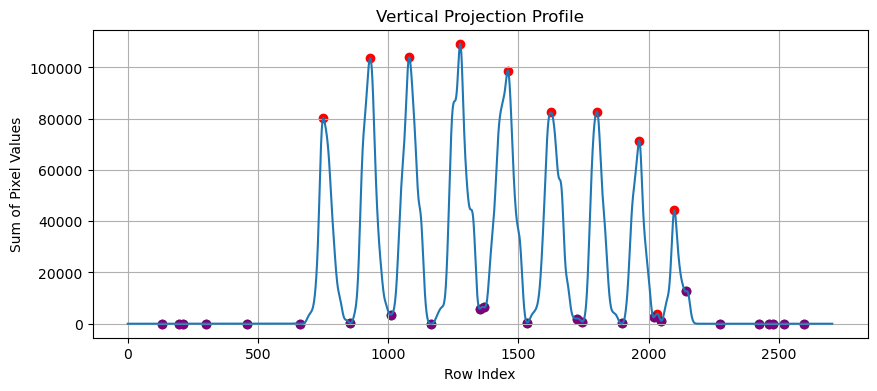

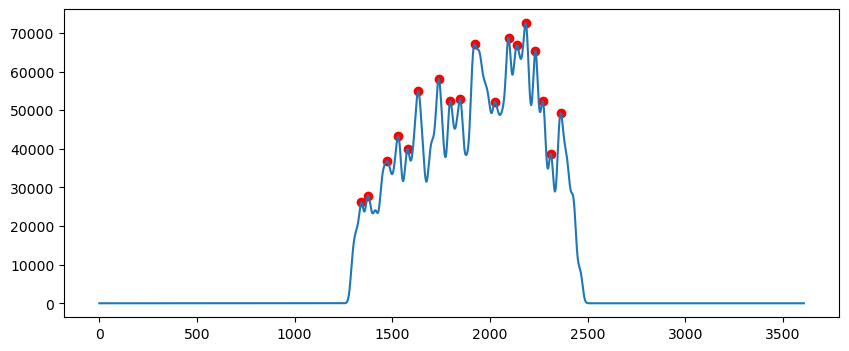

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import PIL.ImageOps
import math

def filter_between_peaks(greens, reds):
    max = reds[-1]
    min = reds[0]
    keeped_peaks = []
    for i in greens:
        if i >= min and i <= max:
            keeped_peaks.append(i)
    
    return keeped_peaks



example_text_image_pillow = Image.open("image-data\P632-Fg002-R-C01-R01-binarized.jpg")

def horizontalProjectionAndSkewAlignment(image, skew_range = 15): #line segmentation and skew alignment 
    skews = range(-skew_range,skew_range)
    skew_val = 0
    peaks_locs = None
    num_peaks = math.inf
    for skew in skews:
        temp_rotated_image  = image.rotate(skew,fillcolor = 'white')
        projection = np.sum(temp_rotated_image, axis=1)
        smoothed_projection = gaussian_filter1d(projection, sigma=6)
        inverted_projection = np.max(smoothed_projection) - smoothed_projection
        peaks, _  = find_peaks(inverted_projection, prominence=200) 
        current_num_peaks = len(peaks)
        if  current_num_peaks < num_peaks:
            skew_val = skew
            peaks_locs = peaks
            peaks_final, _ = find_peaks(smoothed_projection)
    plt.figure(figsize=(10, 4))
    plt.plot(inverted_projection)
    plt.scatter(peaks, [inverted_projection[peak] for peak in peaks], color='red', label='peak')
    plt.scatter(peaks_final,[inverted_projection[peak] for peak in peaks_final], color='green', label='white peak')
    line_peaks = filter_between_peaks(peaks_final, peaks_locs)
    plt.scatter(peaks_final,[inverted_projection[peak] for peak in peaks_final], color='purple', label='white peak')
    plt.title("Vertical Projection Profile")
    plt.xlabel("Row Index")
    plt.ylabel("Sum of Pixel Values")
    plt.grid(True)
    plt.show()
    return skew_val, line_peaks, temp_rotated_image


#def verticalProjection(image, line_peaks): #word segementation by line, without skew alignment
  #  plt.figure(figsize=(10, 4))
  #  for line, i in enumerate(line_peaks):
  #      plt.imshow(image[line], cmap='gray')
        #plt.plot(inverted_projection)
        #projection = np.sum(image[i], axis=0)
        #smoothed_projection = gaussian_filter1d(projection, sigma=10)
        #inverted_projection = np.max(smoothed_projection) - smoothed_projection
        #word_peaks, _  = find_peaks(inverted_projection, prominence=1000)
        #plt.figure(figsize=(10, 4))
        #plt.plot(inverted_projection)
        #plt.scatter(word_peaks, [inverted_projection[peak] for peak in word_peaks], color='red', label='peak')
  #  return word_peaks

skew_val, line_peaks, rotated_image = horizontalProjectionAndSkewAlignment(example_text_image_pillow, 5)
#word_peaks = verticalProjection(rotated_image)


In [141]:
skew_val

4

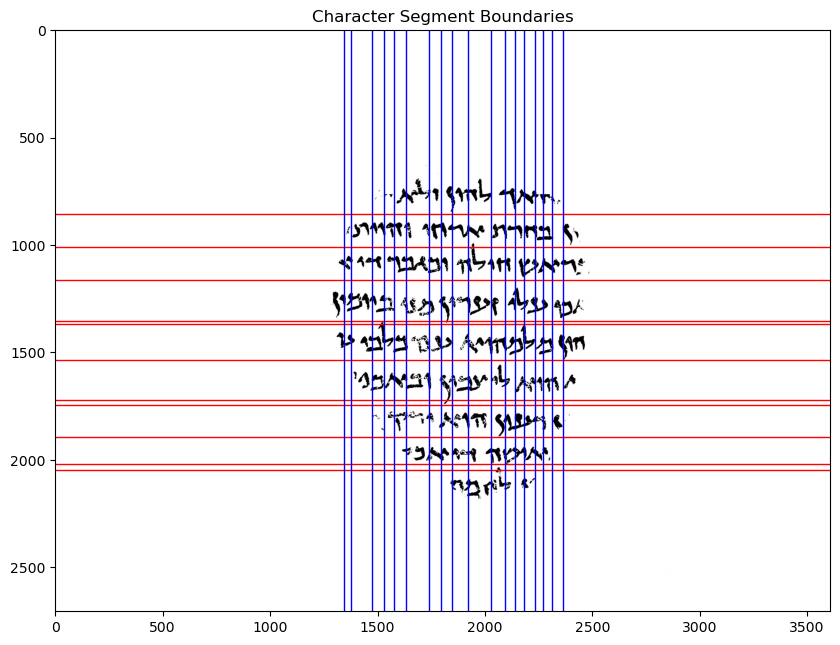

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(example_text_image_pillow, cmap='gray')
for peak in line_peaks:
    plt.axhline(peak, color='red', linestyle='-', linewidth=1)
plt.title("Character Segment Boundaries")
plt.show()

In [ ]:
def vertical_projection(peak_locs, image):
    